# ICEGRAV Real Application

Apply the dual-layer gradient-boosted (GB) equivalent sources (EQS) approach with block K-fold cross validation (CV) to the real ICEGRAV data. The data file needed was created in notebook 04_icegrav_datasets.ipynb.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import griddata
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from pathlib import Path
from IPython.display import Image
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load data

In [3]:
icegrav = pd.read_csv('../data/icegrav.csv', header=0)
coordinates = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 30)]).T

In [4]:
grid_spacing = 5e3
region = vd.get_region(coordinates)
grid_coordinates = vd.grid_coordinates(region, spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=28e3, coordinates=grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
coordinates_km = [coord / 1000 for coord in coordinates]
grid_coordinates_km = [coord / 1000 for coord in grid_coordinates]

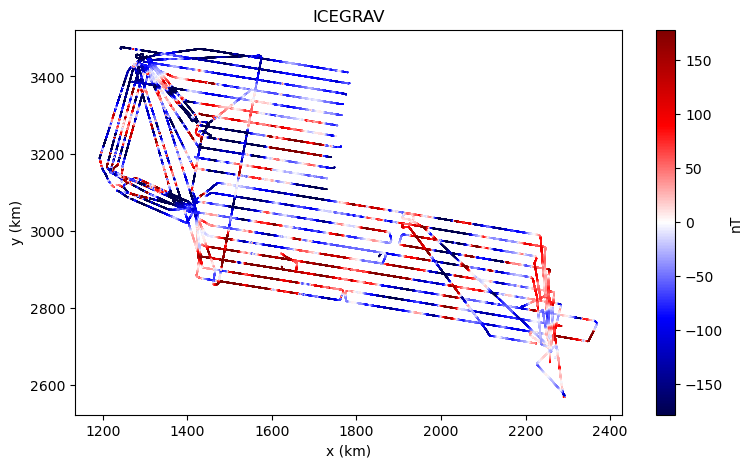

In [5]:
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
scale_icegrav = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav)
plt.title("ICEGRAV")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Fit Deep EQS layer

In [6]:
block_spacing = 15e3
reducer = vd.BlockReduce(
    reduction="median",
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.3)),
    drop_coords=False
)
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav.MagL)

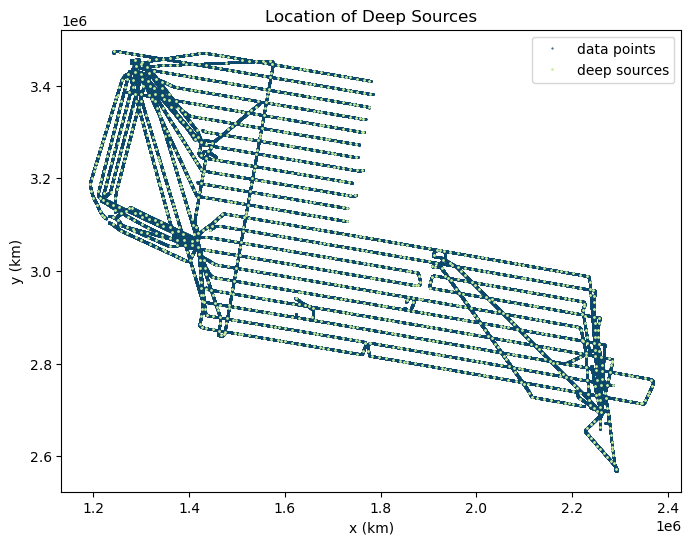

In [7]:
plt.figure(figsize=(8,6))
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], ".", color="#cff09e", markersize=2, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.legend()
plt.show()

In [8]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep = [55e3, 56e3, 57e3, 58e3, 59e3, 60e3, 61e3, 62e3, 63e3, 64e3, 65e3]#[spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.5, spacing*5, spacing*5.5, spacing*6]
dampings_deep = [1e-1, 1e0, 1e1, 1e2, 1e3]#[1e0, 1e1, 1e2, 1e3, 1e4]

In [9]:
parameter_sets_deep = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep, depths_deep)
]
print("Number of combinations:", len(parameter_sets_deep))

Number of combinations: 55


In [10]:
%%time
kfold = vd.BlockKFold(
    spacing=200e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores_deep = []
damping_deep = []
source_depth_deep = []
for parameters in parameter_sets_deep:    
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_blocked[test] - predicted)**2)))
    scores_deep.append(np.mean(tmp))
    damping_deep.append(parameters['damping'])
    source_depth_deep.append(parameters['depth'])

CPU times: user 12min 48s, sys: 10min 3s, total: 22min 51s
Wall time: 54.9 s


Best parameters: {'damping': 10.0, 'depth': 59000.0}
Best RMSE: 107.206 nT


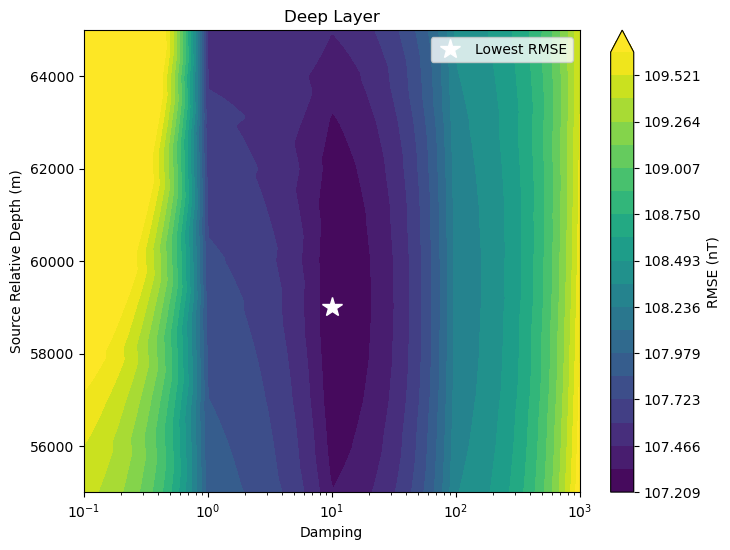

In [27]:
damping_values_deep = np.array(damping_deep)
depth_values_deep = np.array(source_depth_deep)
score_values_deep = np.array(scores_deep)

best_deep = np.argmin(score_values_deep)
best_damping_deep = damping_values_deep[best_deep]
best_depth_deep = depth_values_deep[best_deep]
best_rmse_deep = score_values_deep[best_deep]
best_params_deep = parameter_sets_deep[best_deep]
print("Best parameters:", best_params_deep)
print(f"Best RMSE: {best_rmse_deep:.3f} nT")

x_deep = np.logspace(np.log10(damping_values_deep.min()), np.log10(damping_values_deep.max()), 200)
y_deep = np.linspace(depth_values_deep.min(), depth_values_deep.max(), 200)
X_deep, Y_deep = np.meshgrid(x_deep, y_deep)
Z_deep = griddata(
    (damping_values_deep, depth_values_deep),
    score_values_deep,
    (X_deep, Y_deep),
    method='linear',
)

plt.figure(figsize=(8, 6))
levels_deep = np.linspace(
    Z_deep.min(),
    np.nanpercentile(score_values_deep, 80),
    20,
)
c = plt.contourf(
    X_deep,
    Y_deep,
    Z_deep,
    levels=levels_deep,
    cmap="viridis",
    extend='max',
)
plt.plot(
    best_damping_deep,
    best_depth_deep,
    '*',
    color='white',
    markersize=15,
    label='Lowest RMSE'
)
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Deep Layer")
plt.show()

In [12]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav.MagL - tfa_deep

source height: -56113.1
CPU times: user 15.3 s, sys: 2.02 s, total: 17.3 s
Wall time: 771 ms


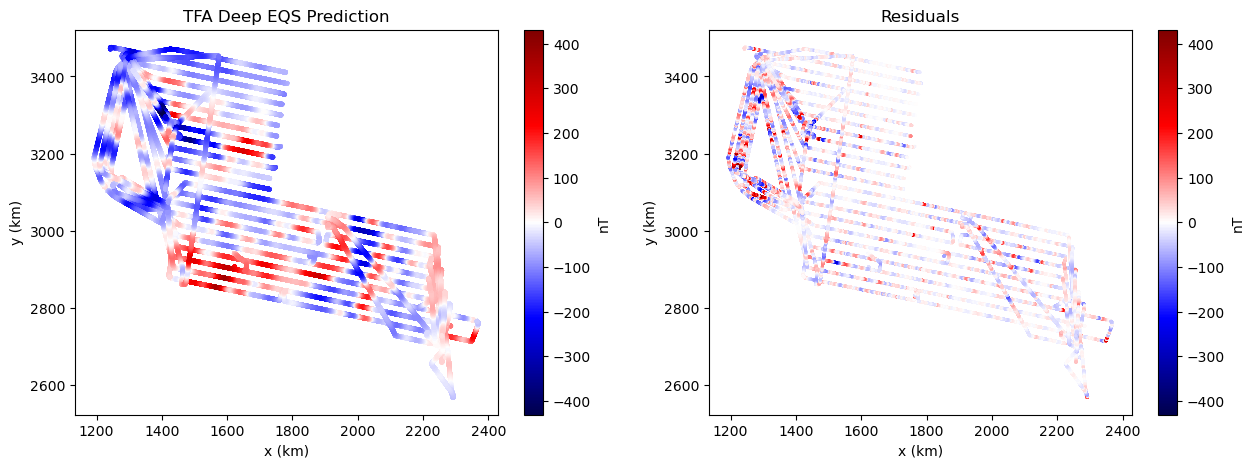

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates_km[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
#scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates_km[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with the shallow GB EQS layer

In [14]:
window_size = 400e3
dampings_shallow = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5]
depths_shallow = [9e3, 10e3, 11e3, 12e3, 13e3] #[5e3, 10e3, 15e3, 20e3, 25e3]

parameter_sets_shallow = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow, depths_shallow)
]
print("Number of combinations:", len(parameter_sets_shallow))

Number of combinations: 30


In [15]:
%%time
kfold = vd.BlockKFold(
    spacing=20e3,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores_shallow = []
damping_shallow = []
source_depth_shallow = []
for parameters in parameter_sets_shallow:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.sqrt(np.nanmean((tfa_residuals[test] - predicted)**2)))
    scores_shallow.append(np.mean(tmp))
    damping_shallow.append(parameters['damping'])
    source_depth_shallow.append(parameters['depth'])

{'damping': 1.0, 'depth': 9000.0}
{'damping': 1.0, 'depth': 10000.0}
{'damping': 1.0, 'depth': 11000.0}
{'damping': 1.0, 'depth': 12000.0}
{'damping': 1.0, 'depth': 13000.0}
{'damping': 10.0, 'depth': 9000.0}
{'damping': 10.0, 'depth': 10000.0}
{'damping': 10.0, 'depth': 11000.0}
{'damping': 10.0, 'depth': 12000.0}
{'damping': 10.0, 'depth': 13000.0}
{'damping': 100.0, 'depth': 9000.0}
{'damping': 100.0, 'depth': 10000.0}
{'damping': 100.0, 'depth': 11000.0}
{'damping': 100.0, 'depth': 12000.0}
{'damping': 100.0, 'depth': 13000.0}
{'damping': 1000.0, 'depth': 9000.0}
{'damping': 1000.0, 'depth': 10000.0}
{'damping': 1000.0, 'depth': 11000.0}
{'damping': 1000.0, 'depth': 12000.0}
{'damping': 1000.0, 'depth': 13000.0}
{'damping': 10000.0, 'depth': 9000.0}
{'damping': 10000.0, 'depth': 10000.0}
{'damping': 10000.0, 'depth': 11000.0}
{'damping': 10000.0, 'depth': 12000.0}
{'damping': 10000.0, 'depth': 13000.0}
{'damping': 100000.0, 'depth': 9000.0}
{'damping': 100000.0, 'depth': 10000.0}
{

Best parameters: {'damping': 100.0, 'depth': 11000.0}
Best RMSE: 51.672 nT


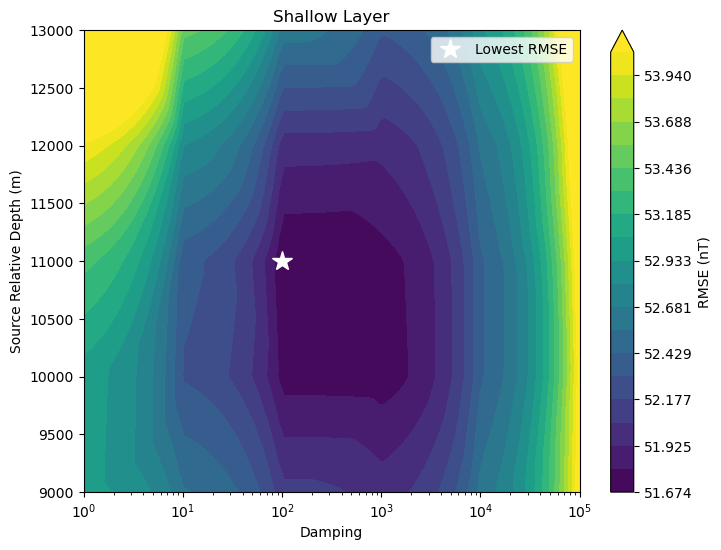

In [28]:
damping_values_shallow = np.array(damping_shallow)
depth_values_shallow = np.array(source_depth_shallow)
score_values_shallow = np.array(scores_shallow)

best_shallow = np.argmin(score_values_shallow)
best_damping_shallow = damping_values_shallow[best_shallow]
best_depth_shallow = depth_values_shallow[best_shallow]
best_rmse_shallow = score_values_shallow[best_shallow]
best_params_shallow = parameter_sets_shallow[best_shallow]
print("Best parameters:", best_params_shallow)
print(f"Best RMSE: {best_rmse_shallow:.3f} nT")

x_shallow = np.logspace(np.log10(damping_values_shallow.min()), np.log10(damping_values_shallow.max()), 100)
y_shallow = np.linspace(depth_values_shallow.min(), depth_values_shallow.max(), 100)
X_shallow, Y_shallow = np.meshgrid(x_shallow, y_shallow)

Z_shallow = griddata(
    (damping_values_shallow, depth_values_shallow),
    score_values_shallow,
    (X_shallow, Y_shallow),
    method='linear'
)
plt.figure(figsize=(8, 6))
levels_shallow = np.linspace(
    Z_shallow.min(),
    np.nanpercentile(score_values_shallow, 80),
    20,
)
c = plt.contourf(
    X_shallow,
    Y_shallow,
    Z_shallow,
    levels=levels_shallow,
    cmap="viridis",
    extend='max',
)
plt.plot(
    best_damping_shallow,
    best_depth_shallow,
    '*',
    color='white',
    markersize=15,
    label='Lowest RMSE'
)
plt.xscale('log')
plt.xlabel('Damping')
plt.ylabel('Source Relative Depth (m)')
plt.colorbar(c, label='RMSE (nT)')
plt.legend()
plt.title("Shallow Layer")
plt.show()

In [17]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow[best_shallow]['damping'],
    depth=parameter_sets_shallow[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 8min 42s, sys: 1min 8s, total: 9min 50s
Wall time: 1min 43s


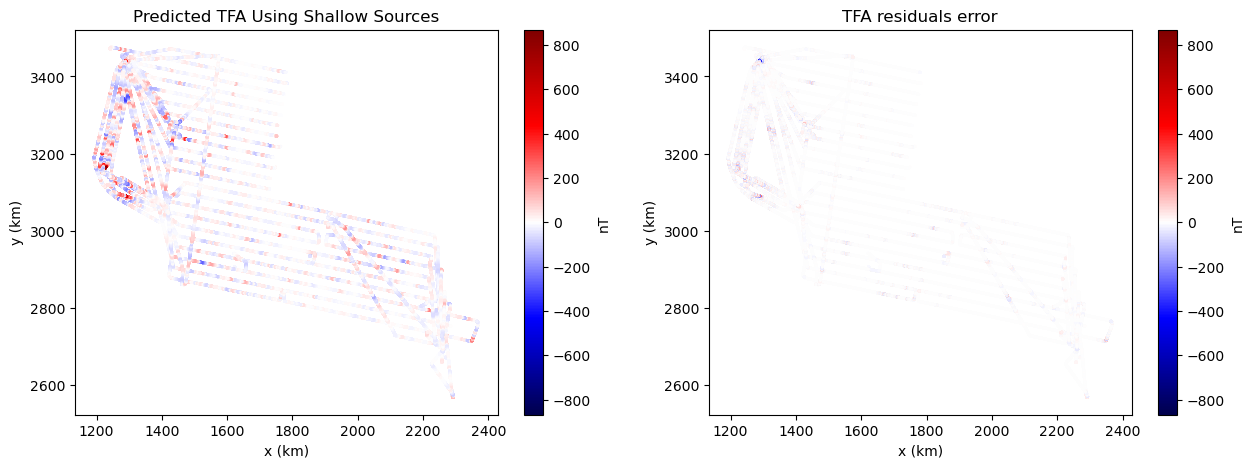

In [18]:
tfa_shallow_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)
error_shallow_predicted = tfa_residuals - tfa_shallow_predicted

plt.figure(figsize=(15,5))
scale_shallow_predicted = vd.maxabs(tfa_shallow_predicted)
plt.subplot(1,2,1)
plt.scatter(*coordinates_km[:2], c=tfa_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates_km[:2], c=error_shallow_predicted, cmap="seismic", s=1, vmin=-scale_shallow_predicted, vmax=scale_shallow_predicted)
plt.title("TFA residuals error")
plt.xlabel("x (km)")
plt.ylabel("y (km)")
plt.colorbar(label="nT")
plt.show()

## Prediction

In [19]:
%%time
predicted_b = eqs_deep.predict(coordinates) + eqs_shallow.predict(coordinates)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = icegrav.MagL - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))
nrmse_tfa = rmse_tfa / (np.nanmax(icegrav.MagL) - np.nanmin(icegrav.MagL))

predicted_b_grid = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa_grid = eqs.total_field_anomaly(predicted_b_grid, field_direction)
predicted_bnorm_grid = np.sqrt(sum(c**2 for c in predicted_b_grid))

CPU times: user 59.6 s, sys: 4.3 ms, total: 59.6 s
Wall time: 1.68 s


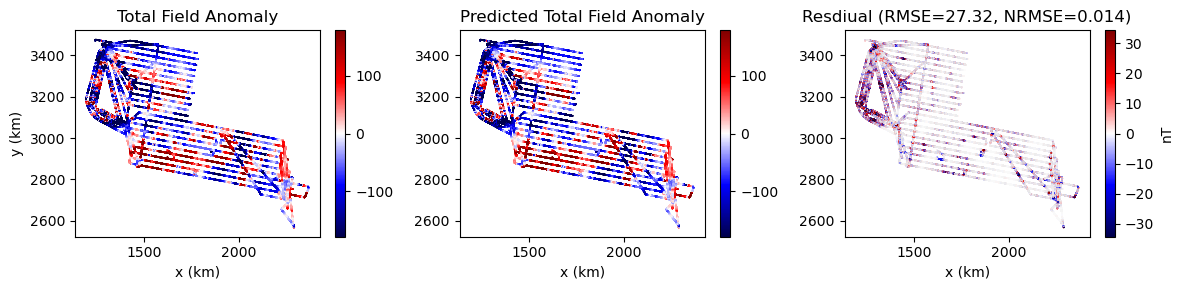

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
plot1 = ax[0].scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[0].set_title("Total Field Anomaly")
ax[0].set_ylabel("y (km)")
ax[0].set_xlabel("x (km)")
fig.colorbar(plot1, ax=ax[0])

plot2 = ax[1].scatter(
    *coordinates_km[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
ax[1].set_title("Predicted Total Field Anomaly")
ax[1].set_xlabel("x (km)")
fig.colorbar(plot2, ax=ax[1])

scale_error_tfa = vd.maxabs(error_tfa) 
scale_error_tfa = np.nanpercentile(error_tfa, 99)
plot3 = ax[2].scatter(
    *coordinates_km[:2],
    c=error_tfa,
    cmap="seismic",
    s=0.001,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
ax[2].set_title(f'Resdiual (RMSE={np.round(rmse_tfa,2)}, NRMSE={np.round(nrmse_tfa, 3)})')
ax[2].set_xlabel("x (km)")
fig.colorbar(plot3, ax=ax[2], label="nT")

fig.tight_layout()
fig.show()

### Show a profile line

In [21]:
test = icegrav
test['predicted_tfa'] = predicted_tfa
flight_12 = test[test['Flight_ID'] == 12]
flight_12 = flight_12[flight_12['y'] <= 2.96e6]
flight_12 = flight_12[flight_12['y'] >= 2.81e6]
coords_flight12 = [flight_12.x, flight_12.y, flight_12.Height_WGS1984]
coords_flight12_km = [coord / 1000 for coord in coords_flight12]

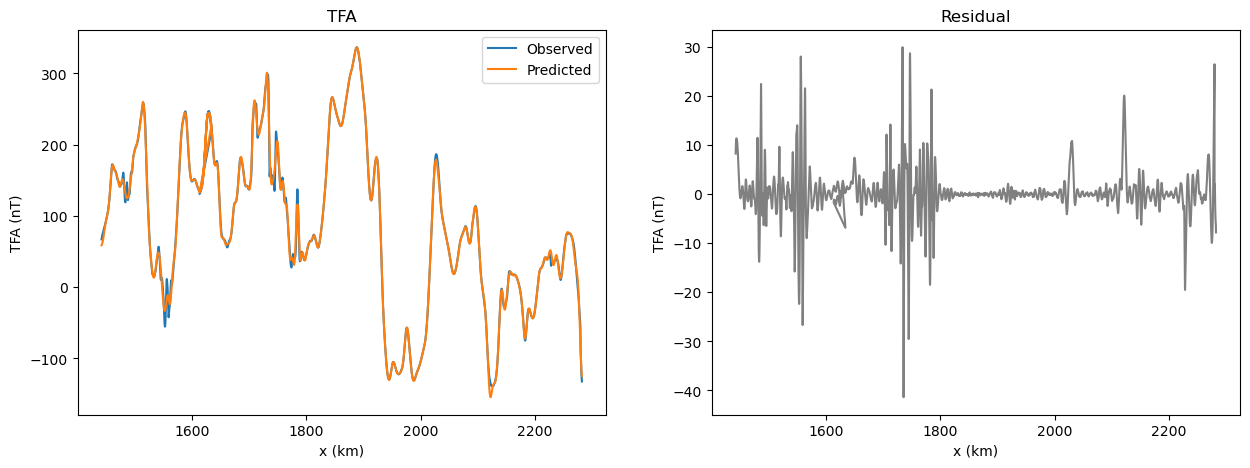

In [22]:
flight12_residuals = flight_12.MagL - flight_12.predicted_tfa

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(coords_flight12_km[0], flight_12.MagL, label='Observed', linewidth=1.5)
plt.plot(coords_flight12_km[0], flight_12.predicted_tfa, label='Predicted', linewidth=1.5)
plt.title("TFA")
plt.xlabel("x (km)")
plt.ylabel("TFA (nT)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(coords_flight12_km[0], flight12_residuals, color='gray', linewidth=1.5)
plt.title("Residual")
plt.xlabel("x (km)")
plt.ylabel("TFA (nT)")
plt.show()

In [23]:
import matplotlib.colors as mcolors
# Define a custom colormap similar to the red portion of the seismic colour scheme for the norm of b figures.
colours = [(1, 1, 1), (1, 0.3, 0.3), (1, 0, 0), (0.5, 0, 0)]  # White -> bright light red -> bright red -> dark red
n_bins = 100  
red_cm = mcolors.LinearSegmentedColormap.from_list("white_to_red", colours, N=n_bins)
red_norm = mcolors.Normalize(vmin=0, vmax=np.nanpercentile(predicted_bnorm_grid, 99))# Normalise with the bnorm range

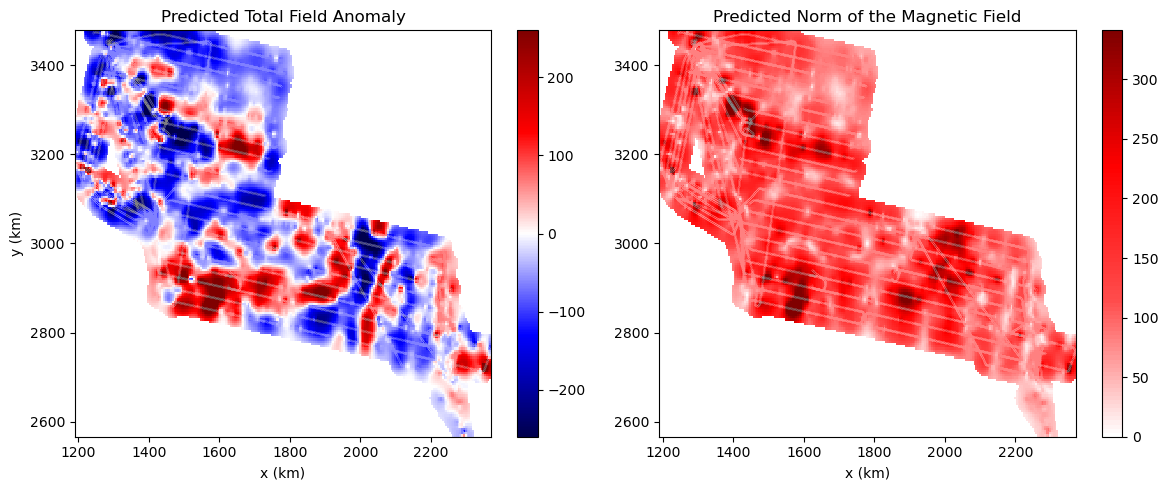

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
#scale_predicted_tfa_grid = vd.maxabs(predicted_tfa_grid)
scale_predicted_tfa_grid = np.nanpercentile(predicted_tfa_grid, 99)
plot1 = ax[0].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid,
    #cmap="jet",#"seismic",
    cmap="seismic",    
    #cmap="RdBu_r",
    vmin=-scale_predicted_tfa_grid,
    vmax=scale_predicted_tfa_grid,
)
ax[0].set_title("Predicted Total Field Anomaly")
ax[0].set_xlabel("x (km)")
ax[0].set_ylabel("y (km)")
fig.colorbar(plot1, ax=ax[0])
plot1 = ax[0].plot(
    *coordinates_km[:2],
    'w.',
    markersize=0.01,
)

plot2 = ax[1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid,
    cmap=red_cm,
    norm=red_norm,
)
ax[1].set_title("Predicted Norm of the Magnetic Field")
ax[1].set_xlabel("x (km)")
fig.colorbar(plot2, ax=ax[1])
plot2 = ax[1].plot(
    *coordinates_km[:2],
    'w.',
    markersize=0.01,
)
fig.tight_layout()
fig.show()

## Figures for paper

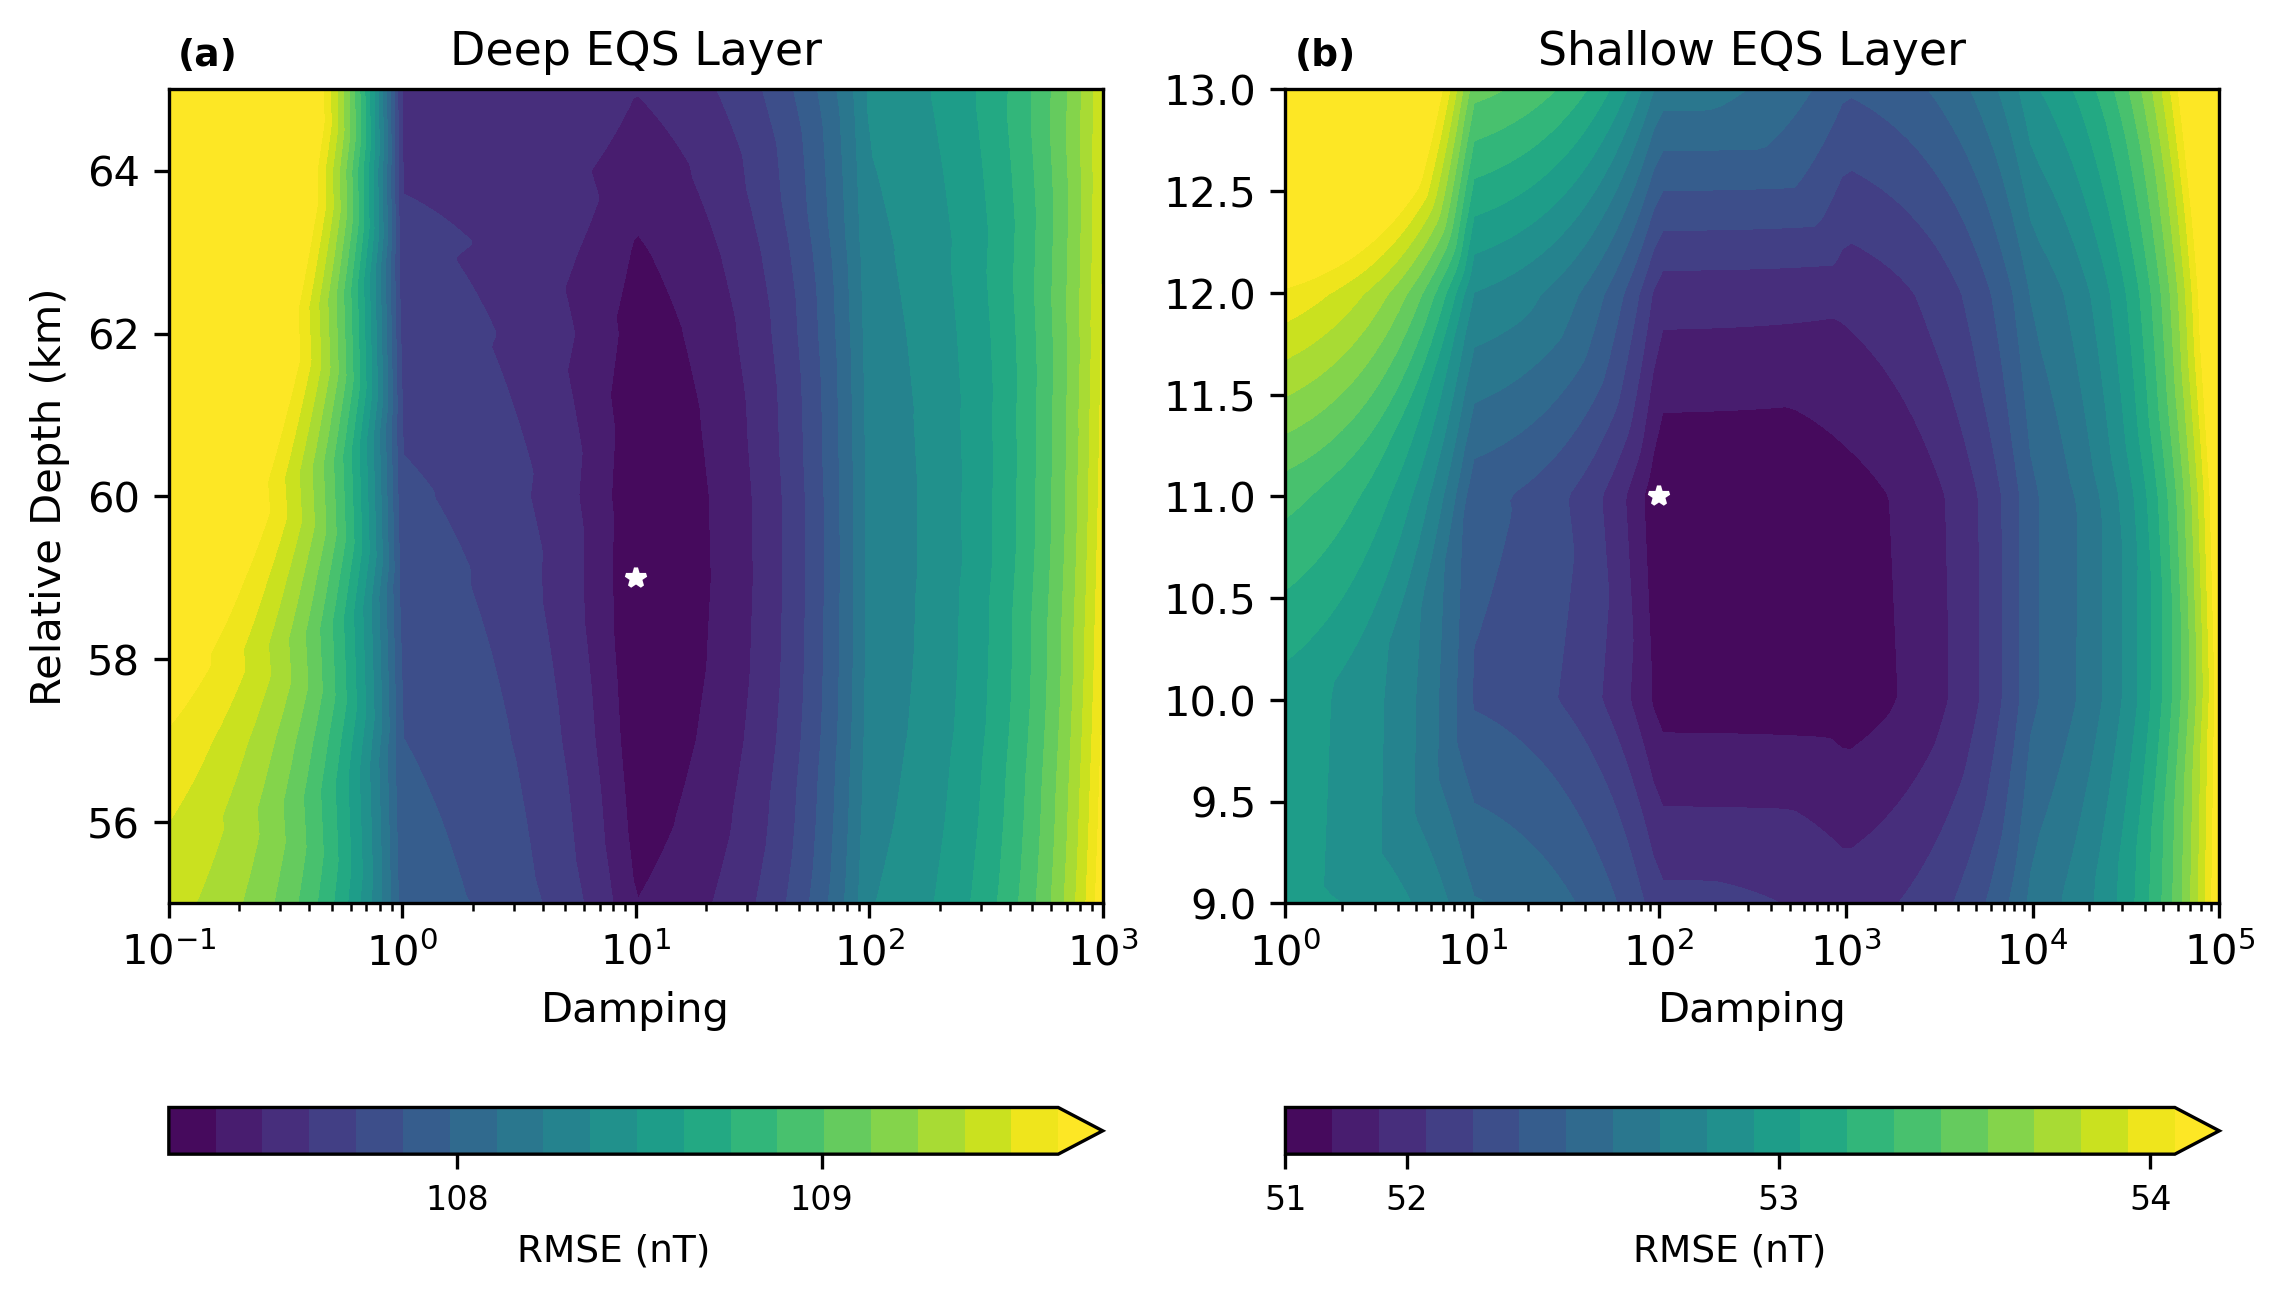

In [44]:
Y_deep_km = [depth / 1000 for depth in Y_deep]
Y_shallow_km = [depth / 1000 for depth in Y_shallow]

fig, axes = plt.subplots(1, 2, figsize=(7.5, 4.2), layout="constrained")

plot1 = axes[0].contourf(
    X_deep,
    Y_deep_km,
    Z_deep,
    levels=levels_deep,
    cmap="viridis",
    extend='max',
)
axes[0].plot(best_damping_deep, best_depth_deep/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[0].set_xscale('log')
axes[0].set_xlabel('Damping', fontsize=10)
axes[0].set_ylabel('Relative Depth (km)', fontsize=10)
axes[0].set_title("Deep EQS Layer", fontsize=11)
axes[0].text(0.01, 1.03, '(a)', transform=axes[0].transAxes, fontsize=9, fontweight='bold')
cbar1 = fig.colorbar(plot1, ax=axes[0], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar1.set_label('RMSE (nT)', fontsize=9)
cbar1.set_ticks(np.arange(int(levels_deep.min())+1, int(levels_deep.max()+1), 1))
cbar1.ax.tick_params(labelsize=8)
cbar1.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

plot2 = axes[1].contourf(
    X_shallow,
    Y_shallow_km,
    Z_shallow,
    levels=levels_shallow,
    cmap="viridis",
    extend='max',
)
axes[1].plot(best_damping_shallow, best_depth_shallow/1000, '*', color='white', markersize=5, label='Lowest RMSE')
axes[1].set_xscale('log')
axes[1].set_xlabel('Damping', fontsize=10)
axes[1].set_title("Shallow EQS Layer", fontsize=11)
axes[1].text(0.01, 1.03, '(b)', transform=axes[1].transAxes, fontsize=9, fontweight='bold')
cbar2 = fig.colorbar(plot2, ax=axes[1], orientation='horizontal', location='bottom', label='RMSE (nT)', pad=0.08)
cbar2.set_label('RMSE (nT)', fontsize=9)
cbar2.set_ticks(np.arange(int(levels_shallow.min()), int(levels_shallow.max()+1), 1))
cbar2.ax.tick_params(labelsize=8)
cbar2.ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# plt.show()
cv_real_figure = Path("..") / "paper" / "figures" / "cv_real.png"
fig.savefig(cv_real_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(cv_real_figure)

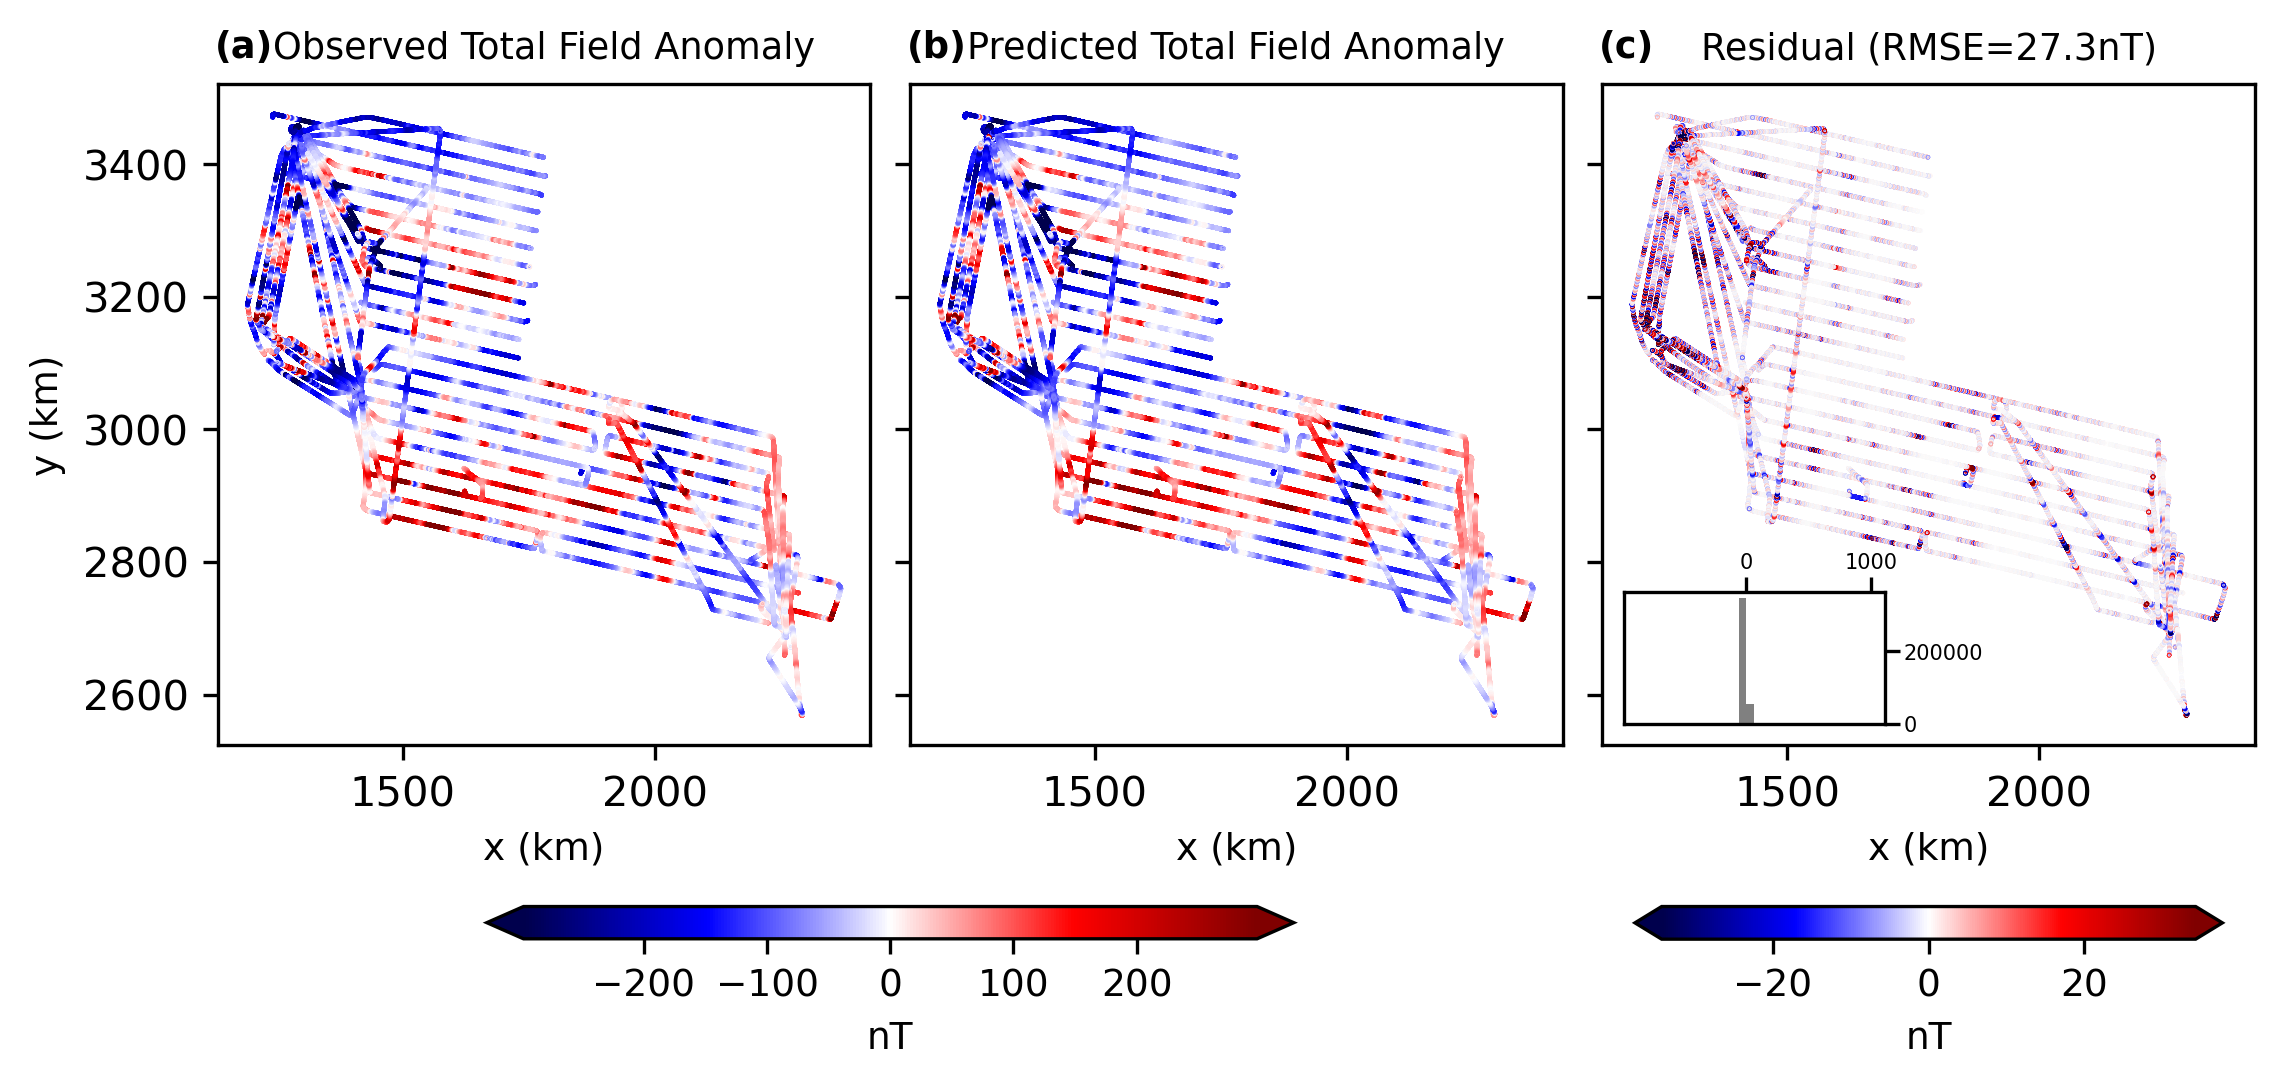

In [46]:
scale_icegrav = np.nanpercentile(icegrav.MagL, 99)
scale_error_tfa = np.nanpercentile(error_tfa, 99)

fig, axes = plt.subplots(1, 3, figsize=(7.5, 3.5), sharey=True, gridspec_kw={'wspace': 0.02}, layout="constrained")
plot1 = axes[0].scatter(
    *coordinates_km[:2],
    c=icegrav.MagL,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
axes[0].set_title("Observed Total Field Anomaly", fontsize=8.8)
axes[0].set_ylabel("y (km)", fontsize=9)
axes[0].set_xlabel("x (km)", fontsize=9)
axes[0].text(-0.005, 1.04, '(a)', transform=axes[0].transAxes, fontsize=8.8, fontweight='bold')

plot2 = axes[1].scatter(
    *coordinates_km[:2],
    c=predicted_tfa,
    cmap="seismic",
    s=0.01,
    vmin=-scale_icegrav,
    vmax=scale_icegrav,
)
axes[1].set_title("Predicted Total Field Anomaly", fontsize=8.8)
axes[1].set_xlabel("x (km)", fontsize=9)
axes[1].text(-0.005, 1.04, '(b)', transform=axes[1].transAxes, fontsize=8.8, fontweight='bold')

cbar1 = fig.colorbar(plot2, ax=axes[:2], orientation='horizontal', extend='both', pad=0.05, shrink=0.60, aspect=25)
cbar1.set_label("nT", fontsize=9)
cbar1.ax.tick_params(labelsize=9)

plot3 = axes[2].scatter(
    *coordinates_km[:2],
    c=error_tfa,
    cmap="seismic",
    s=0.001,
    vmin=-scale_error_tfa,
    vmax=scale_error_tfa,
)
axes[2].set_title(f'Residual (RMSE={np.round(rmse_tfa,1)}nT)', fontsize=8.8)
axes[2].set_xlabel("x (km)", fontsize=9)
axes[2].text(-0.005, 1.04, '(c)', transform=axes[2].transAxes, fontsize=8.8, fontweight='bold')

inset_ax = inset_axes( 
    axes[2],
    width="40%",
    height="20%",
    loc="lower left",
    bbox_to_anchor=(0.001, 0.001, 1, 1),
    bbox_transform=axes[2].transAxes,
)
inset_ax.hist(error_tfa[~np.isnan(error_tfa)], bins=30, color="gray")
inset_ax.tick_params(labelsize=5, pad=1)
inset_ax.xaxis.set_ticks_position('top')
inset_ax.xaxis.set_label_position('top')
inset_ax.yaxis.set_ticks_position('right')
inset_ax.yaxis.set_label_position('right')

cbar2 = fig.colorbar(plot3, ax=axes[2], orientation='horizontal', extend='both', pad=0.05, shrink=0.90, aspect=18)
cbar2.set_label("nT", fontsize=9)
cbar2.ax.tick_params(labelsize=9)

# fig.show()
real_line_pred_figure = Path("..") / "paper" / "figures" / "real_line_pred.png"
fig.savefig(real_line_pred_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(real_line_pred_figure)

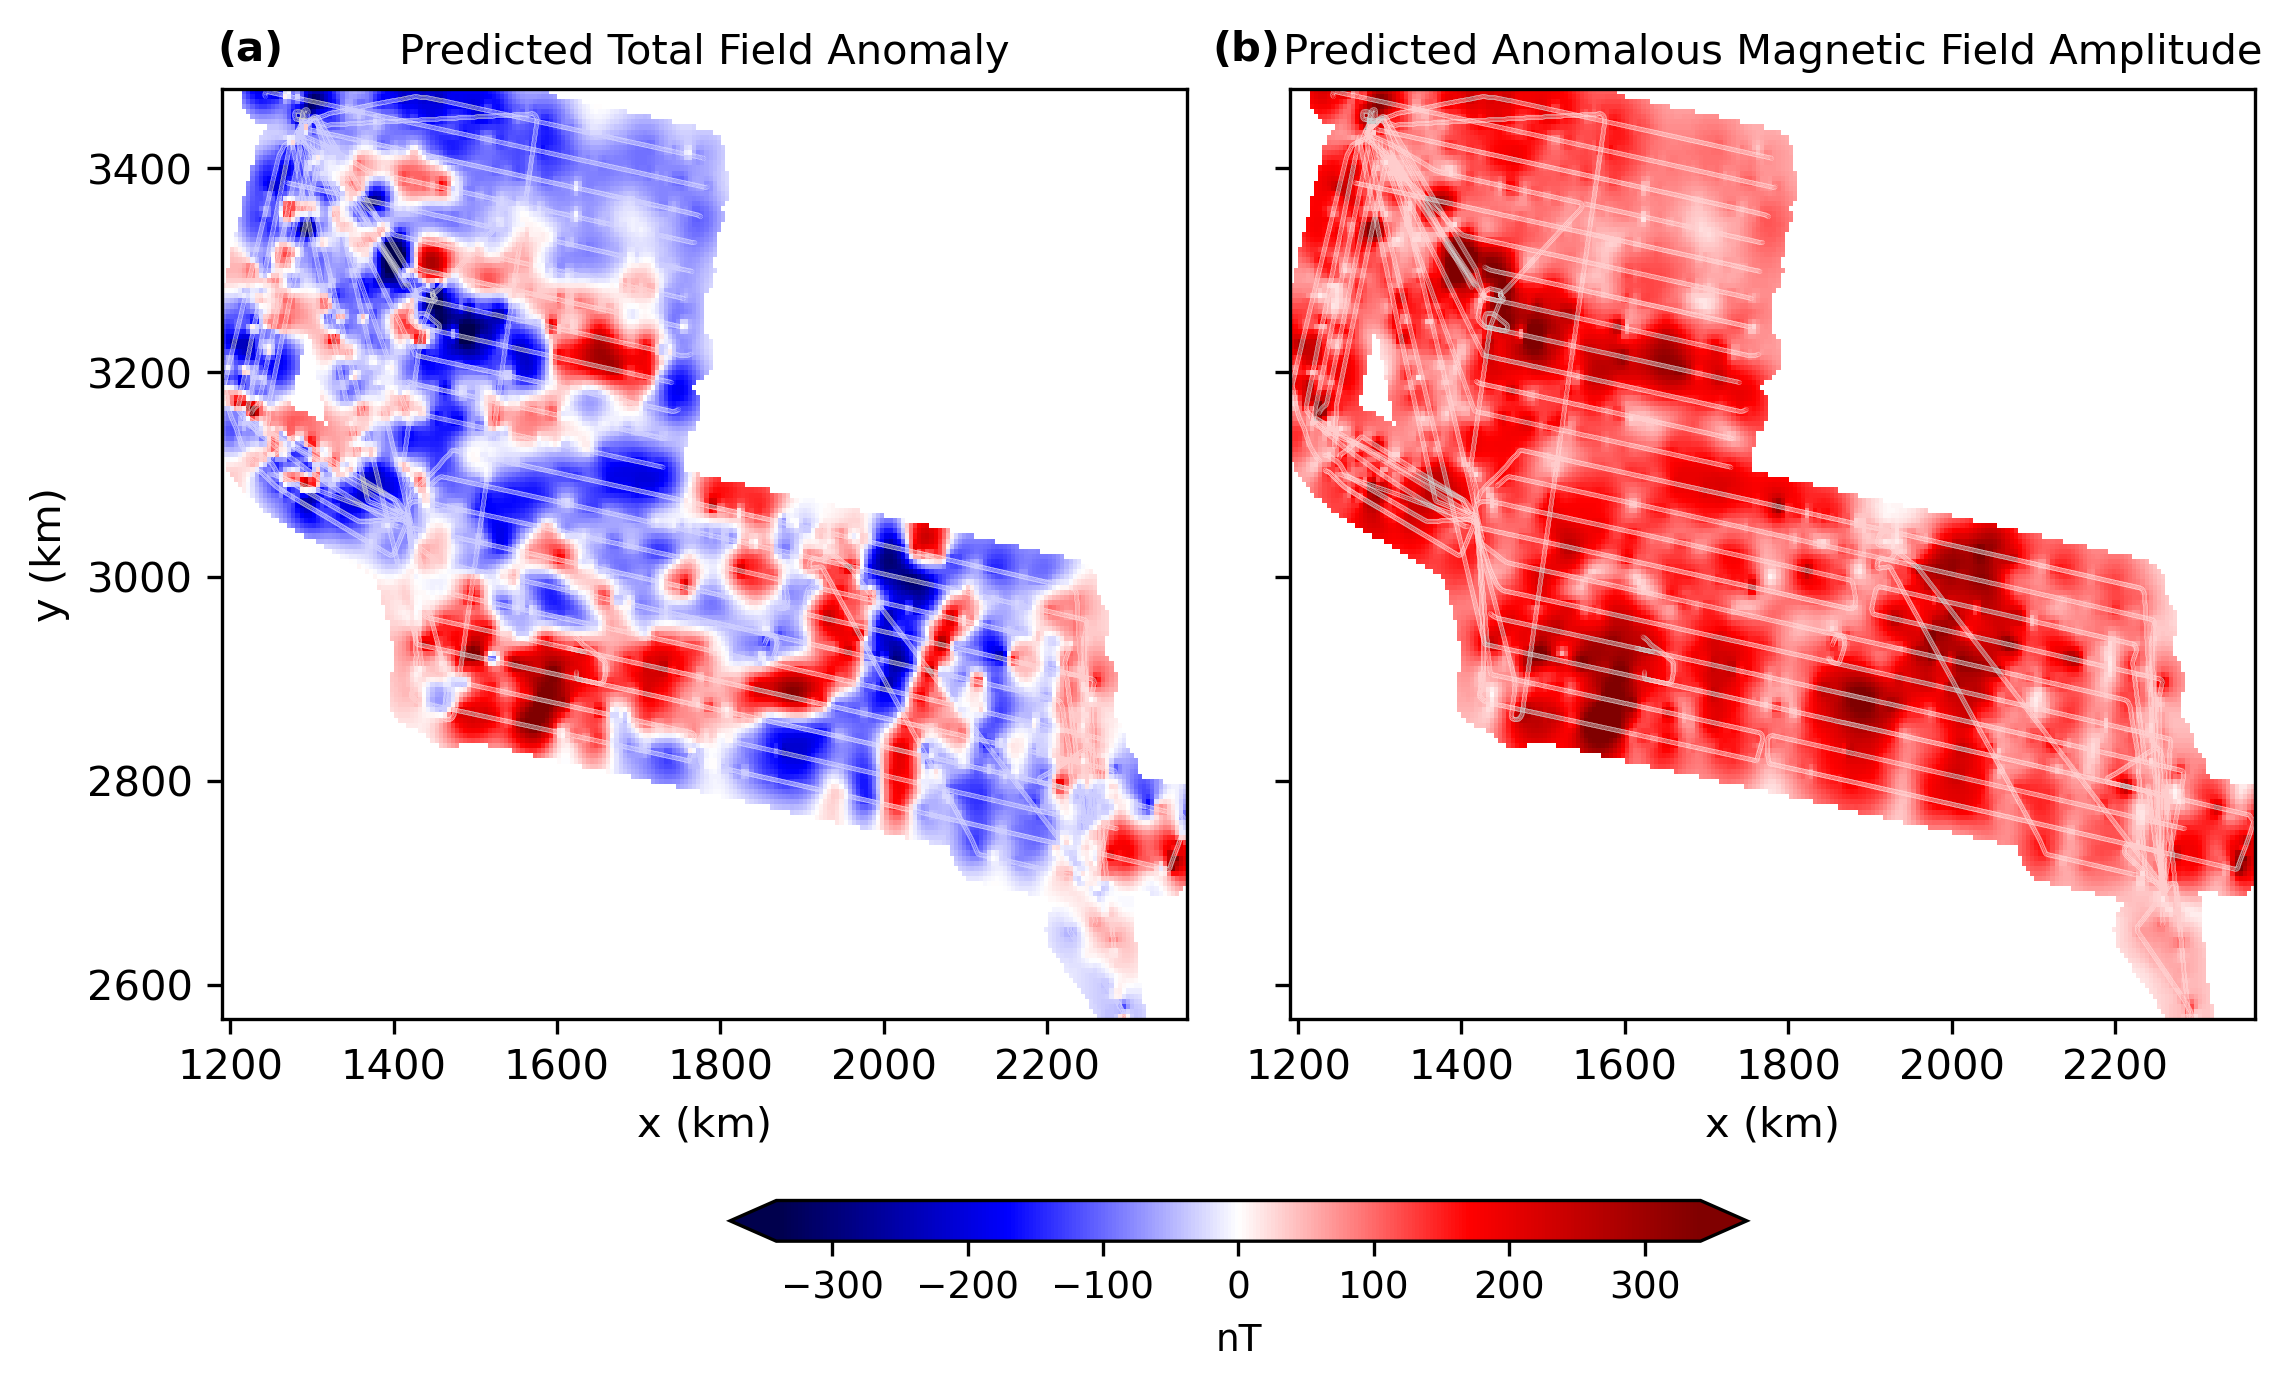

In [26]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(7.5,4.5), gridspec_kw={'wspace': 0.02}, layout="constrained")
# scale_predicted_tfa_grid = np.nanpercentile(predicted_tfa_grid, 99)
scale_predicted_bnorm_grid = np.nanpercentile(predicted_bnorm_grid, 99)
plot1 = ax[0].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_tfa_grid,
    cmap="seismic",    
    vmin=-scale_predicted_bnorm_grid,
    vmax=scale_predicted_bnorm_grid,
)
ax[0].set_title("Predicted Total Field Anomaly", fontsize=10)
ax[0].set_xlabel("x (km)", fontsize=10)
ax[0].set_ylabel("y (km)", fontsize=10)
ax[0].plot(*coordinates_km[:2], 'w.', markersize=0.01)
ax[0].text(-0.005, 1.03, '(a)', transform=ax[0].transAxes, fontsize=10, fontweight='bold')

plot2 = ax[1].pcolormesh(
    *grid_coordinates_km[:2],
    predicted_bnorm_grid,
    cmap="seismic",    
    vmin=-scale_predicted_bnorm_grid,
    vmax=scale_predicted_bnorm_grid,
)
ax[1].set_title("Predicted Anomalous Magnetic Field Amplitude", fontsize=10)
ax[1].set_xlabel("x (km)", fontsize=10)
ax[1].plot(*coordinates_km[:2], 'w.', markersize=0.01)
ax[1].text(-0.08, 1.03, '(b)', transform=ax[1].transAxes, fontsize=10, fontweight='bold')

cbar = fig.colorbar(plot2, ax=ax, orientation='horizontal', extend='both', pad=0.05, shrink=0.5, aspect=25)
cbar.set_label("nT", fontsize=9)
cbar.ax.tick_params(labelsize=9)

# fig.show()
real_grid_pred_figure = Path("..") / "paper" / "figures" / "real_grid_pred.png"
fig.savefig(real_grid_pred_figure, dpi=300, bbox_inches="tight")
plt.close()
Image(real_grid_pred_figure)